In [1]:
import sys
import os
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import json
import time 
import pickle as pkl
import matplotlib.pyplot as plt

currDir = os.path.abspath('')

# root directory for all necessary modules to be loaded
parentDir = os.path.dirname( currDir )

# directory for modules containing model related definitions
modelDefinitionDir = os.path.join( parentDir, 'model_definitions' )

In [2]:
# import necessary modules from the project root dir 
sys.path.append( parentDir )

import config
from elbo_loss import elboLoss
from object_encapsulate import objectIndividual
from paths import *
from report import initReport, meanMetricsReportGen, reportGen
from data.metadata import metaData

In [3]:
# import required modules for utilizing models
sys.path.append( modelDefinitionDir )

from experts import prior_expert, product_of_experts
from image_encoder_decoder import image_encoder, image_decoder
from speech_encoder_decoder import speech_encoder, speech_decoder
from multimodal_variational_autoencoder import Swish, label_decoder, data_iterate, multimodal_variational_autoencoder
from model_utils import *
#model_save, model_load, loss_tracker, returnMeanLogarithmVariance, displayImage, checkIfDisentangled

In [4]:
# Check Graphics card availability
!nvidia-smi -L

GPU 0: GeForce GTX 1060 (UUID: GPU-4c337ed3-4259-ad0c-9a53-1416f3140b94)


In [5]:
# model configurations
numLatents = 300
imageLambda = 1.0
speechLambda = 1.0
available_CUDA = torch.cuda.is_available() # check for CUDA availability

# model Train / Test / Validation configurations
learningRate = 0.001 # 0.0001 0.00001
batchSize = 128
totalEpochs = 1500 # 2000 1500 1000 500 100
NumMiniBatches = 48000 // batchSize
annealEpoch = 200
NumMiniBatchesValidation = 188
NumMiniBatchesTest = 317
consoleLogInterval = 50

In [6]:
dataObject = objectIndividual( 'Bangla', 'Arabic' )

In [7]:
# instantiate train dataset for the instantiated data object
train_data_object = data_iterate( dataObject, data_iterate_config = 'train' )
train_dataset = torch.utils.data.DataLoader( train_data_object, batch_size = batchSize )

# instantiate test dataset for the instantiated data object
test_data_object = data_iterate( dataObject, data_iterate_config = 'test' )
test_dataset = torch.utils.data.DataLoader( test_data_object, batch_size = batchSize )

# instantiate validation dataset for the instantiated data object
validation_data_object = data_iterate( dataObject, data_iterate_config = 'validation' )
validation_dataset = torch.utils.data.DataLoader( validation_data_object, batch_size = batchSize )

Load the model

In [8]:
saveDir = saveDir = os.path.join( parentDir, 'train' )

banglaArabicModel = model_load( saveDir + '//model_best_1500.tar', available_CUDA = True )

# if available_CUDA:
#     device = torch.device("cuda")    
# banglaArabicModel.to(device)

torch.Size([128, 300])

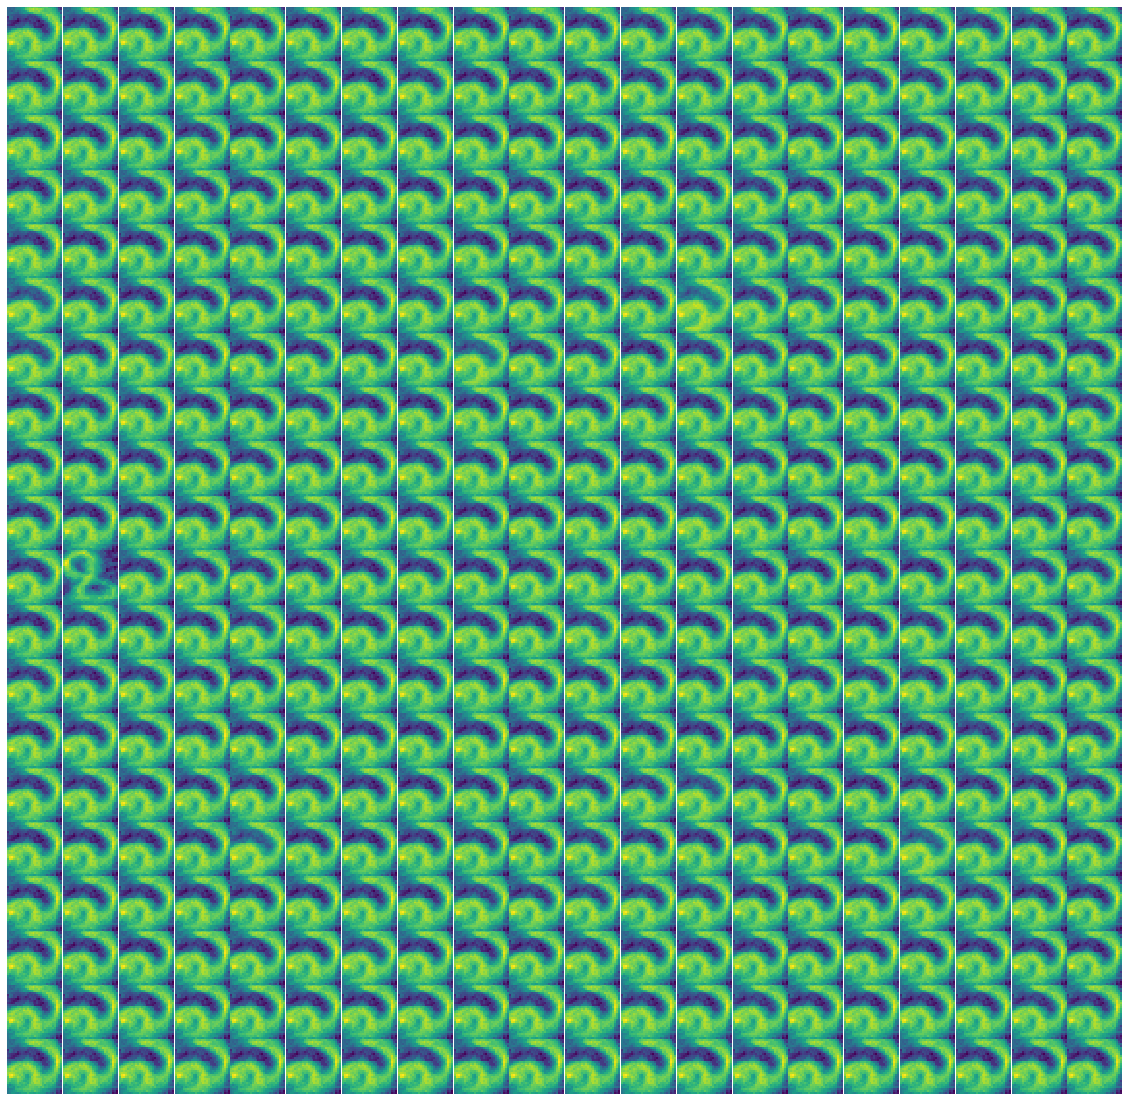

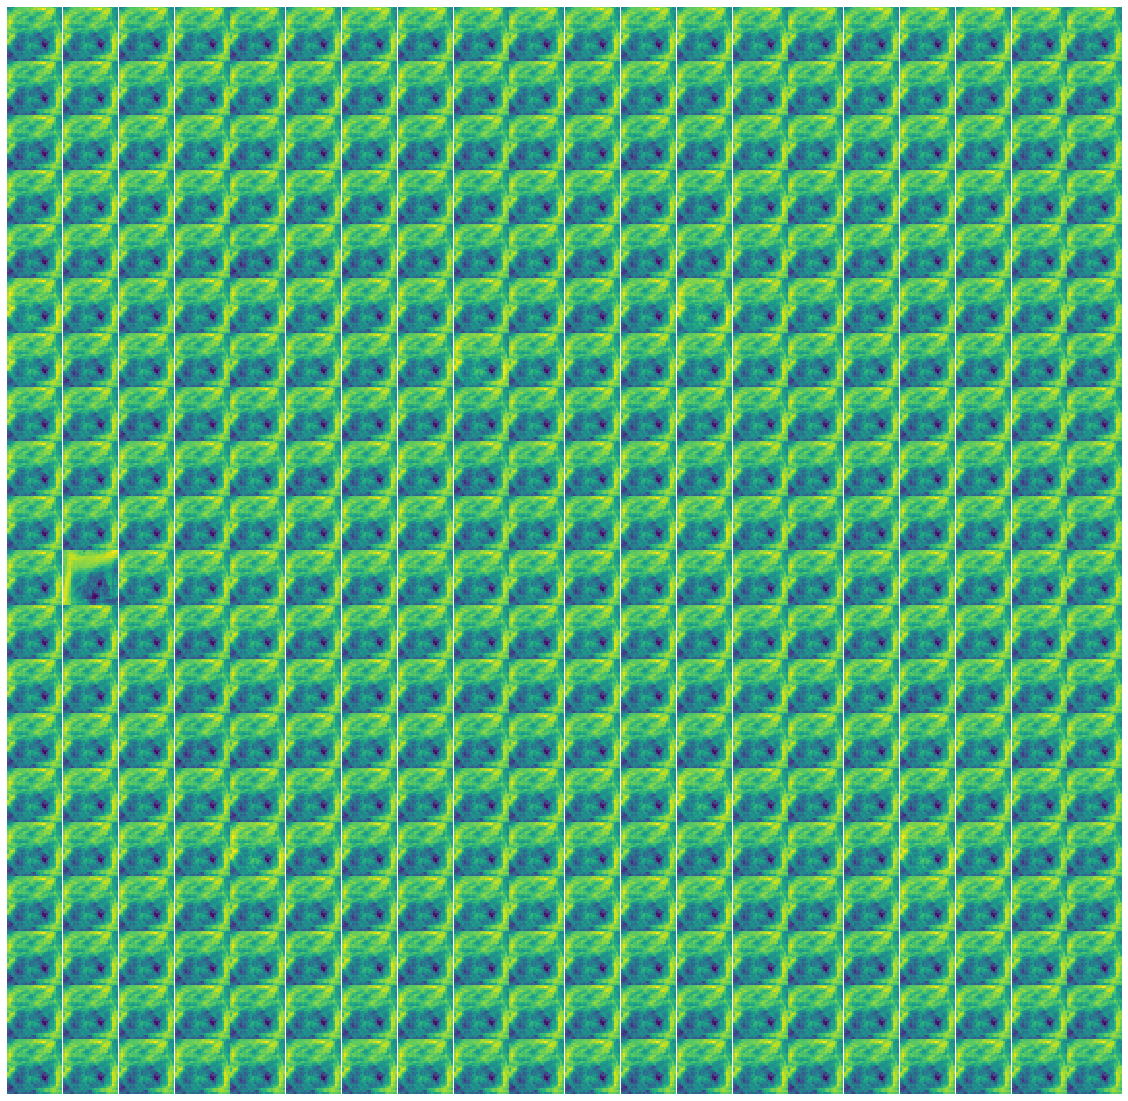

In [9]:
# checking for only one label ==> 9
banglaArabicModelParams = intitiateReparmeterize( banglaArabicModel, test_dataset, 9, False )
disentangledTensor = checkIfDisentangled( banglaArabicModelParams.clone().detach(),
                                          201, torch.device("cpu"), 30, 300
                                        )

displayImage( banglaArabicModel, disentangledTensor )
displayImage( banglaArabicModel, disentangledTensor, False )
banglaArabicModelParams.shape